# Text classification with an RNN

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf

TensorFlow 2.x selected.


Import `matplotlib` and create a helper function to plot graphs:

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).


In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [0]:
encoder = info.features['text'].encoder

In [5]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [6]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [0]:
assert original_string == sample_string

In [8]:
for index in encoded_string:
  print ('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string n the batch:

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Compile the Keras model to configure the training process:

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [13]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 53s 136ms/step - loss: 0.6387 - accuracy: 0.6150 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3449 - accuracy: 0.8585 - val_loss: 0.3417 - val_accuracy: 0.8573
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.2467 - accuracy: 0.9074 - val_loss: 0.3072 - val_accuracy: 0.8786
Epoch 4/10
391/391 [==============================] - 47s 120ms/step - loss: 0.2110 - accuracy: 0.9241 - val_loss: 0.3075 - val_accuracy: 0.8792
Epoch 5/10
391/391 [==============================] - 48s 122ms/step - loss: 0.1814 - accuracy: 0.9370 - val_loss: 0.3191 - val_accuracy: 0.8714
Epoch 6/10
391/391 [==============================] - 48s 122ms/step - loss: 0.1585 - accuracy: 0.9468 - val_loss: 0.3373 - val_accuracy: 0.8661
Epoch 7/10
391/391 [==============================] - 47s 121ms/step - loss: 0.1458 - accuracy: 0.9521 - val_loss: 0.3559 

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 18s 46ms/step - loss: 0.4323 - accuracy: 0.8538
Test Loss: 0.43227009856335036
Test Accuracy: 0.8537600040435791


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sentence, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [17]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.4636742]]


In [18]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.3707672]]


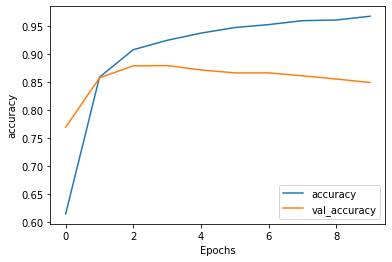

In [19]:
plot_graphs(history, 'accuracy')

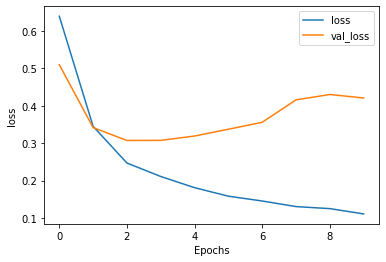

In [20]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 85s 217ms/step - loss: 0.6577 - accuracy: 0.5778 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 80s 204ms/step - loss: 0.3748 - accuracy: 0.8502 - val_loss: 0.3397 - val_accuracy: 0.8656
Epoch 3/10
391/391 [==============================] - 81s 208ms/step - loss: 0.2626 - accuracy: 0.9051 - val_loss: 0.3150 - val_accuracy: 0.8656
Epoch 4/10
391/391 [==============================] - 81s 206ms/step - loss: 0.2188 - accuracy: 0.9266 - val_loss: 0.3366 - val_accuracy: 0.8630
Epoch 5/10
391/391 [==============================] - 81s 207ms/step - loss: 0.1827 - accuracy: 0.9438 - val_loss: 0.3721 - val_accuracy: 0.8630
Epoch 6/10
391/391 [==============================] - 82s 210ms/step - loss: 0.1561 - accuracy: 0.9543 - val_loss: 0.3719 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 82s 210ms/step - loss: 0.1386 - accuracy: 0.9610 - val_loss: 0.4371 

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 33s 85ms/step - loss: 0.5382 - accuracy: 0.8372
Test Loss: 0.5381720934606269
Test Accuracy: 0.8371999859809875


In [25]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.06086913]]


In [26]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.02197997]]


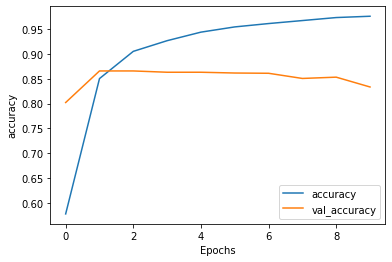

In [27]:
plot_graphs(history, 'accuracy')

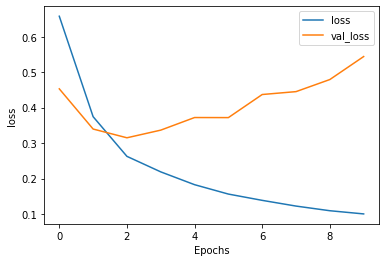

In [28]:
plot_graphs(history, 'loss')